<a href="https://colab.research.google.com/github/widrevitz/widrevitz/blob/main/MLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os
import glob

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"⚡ Using device: {device.upper()}")

# ✅ Sanity check
print("Torch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())


⚡ Using device: CUDA
Torch version: 2.8.0+cu126
GPU available: True


In [2]:
# ✅ Cell 2: Define SmallMLP model
class SmallMLP(nn.Module):
    def __init__(self):
        super(SmallMLP, self).__init__()
        self.flatten = nn.Flatten()          # Flatten 28x28 images into 784-dim vector
        self.fc1 = nn.Linear(28*28, 128)    # First hidden layer
        self.relu = nn.ReLU()                # Activation
        self.fc2 = nn.Linear(128, 64)       # Second hidden layer
        self.fc3 = nn.Linear(64, 10)        # Output layer (10 digits)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ✅ Sanity check: create a temporary model and print architecture
tmp_model = SmallMLP()
print("Model architecture:\n", tmp_model)


Model architecture:
 SmallMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.94MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.0MB/s]

Training samples: 60000
Test samples    : 10000


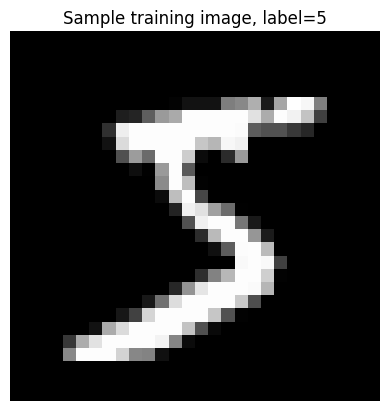

In [3]:
# ✅ Cell 3: Load MNIST dataset
transform = transforms.ToTensor()

# Download training and test datasets
train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

# ✅ Sanity checks
print("Training samples:", len(train_set))
print("Test samples    :", len(test_set))

# Look at a sample image
sample_img, sample_label = train_set[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Sample training image, label={sample_label}")
plt.axis('off')
plt.show()


In [4]:
# ✅ Cell 4: Train SmallMLP
model = SmallMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3  # small demo for quick runs
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

# ✅ Sanity check on a batch from test set
sample_images, sample_labels = next(iter(test_loader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
outputs = model(sample_images)
preds = outputs.argmax(dim=1)
print("Sample predictions:", preds[:10].cpu().numpy())
print("Sample labels     :", sample_labels[:10].cpu().numpy())


Epoch [1/3], Avg Loss: 0.3376
Epoch [2/3], Avg Loss: 0.1387
Epoch [3/3], Avg Loss: 0.0935
Sample predictions: [7 2 1 0 4 1 4 9 5 9]
Sample labels     : [7 2 1 0 4 1 4 9 5 9]


In [5]:
# ✅ Cell 5: Save model state_dict
save_path = "mlp_mnist_state_dict.pth"
torch.save(model.state_dict(), save_path)
size_kb = os.path.getsize(save_path) / 1024
print(f"✅ Model state_dict saved: {save_path} ({size_kb:.2f} KB)")



✅ Model state_dict saved: mlp_mnist_state_dict.pth (430.42 KB)


In [6]:
# ✅ Cell 6: Save MNIST test images as PNGs
from torchvision.utils import save_image

os.makedirs("saved_digits", exist_ok=True)
raw_test = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

N = 20  # number of images to save
for i in range(N):
    img_tensor, label = raw_test[i]
    save_path = f"saved_digits/digit_{i}_label_{label}.png"
    save_image(img_tensor, save_path)

# Confirm saved files
saved_files = sorted(glob.glob("saved_digits/*.png"))
print(f"✅ Saved {len(saved_files)} images. Sample files: {saved_files[:5]}")


✅ Saved 20 images. Sample files: ['saved_digits/digit_0_label_7.png', 'saved_digits/digit_10_label_0.png', 'saved_digits/digit_11_label_6.png', 'saved_digits/digit_12_label_9.png', 'saved_digits/digit_13_label_0.png']


In [8]:
# ✅ Cell 7: Helper function to predict digits from PNGs
def predict_from_folder(model, device, folder="saved_digits"):
    tf = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor()])
    paths = sorted(glob.glob(f"{folder}/*.png"))

    if not paths:
        print("❌ No images found in", folder)
        return

    model.eval()
    with torch.no_grad():
        for p in paths:
            pil_img = Image.open(p).convert("L")  # grayscale
            # Invert if background is dark
            if sum(pil_img.getdata()) / (pil_img.width * pil_img.height) < 100:
                pil_img = ImageOps.invert(pil_img)

            tensor = tf(pil_img).unsqueeze(0).to(device)
            output = model(tensor)
            pred = int(output.argmax(dim=1).item())

            # Show image with prediction
            plt.imshow(pil_img, cmap='gray')
            plt.title(f"{os.path.basename(p)} -> Pred: {pred}")
            plt.axis('off')
            plt.show()


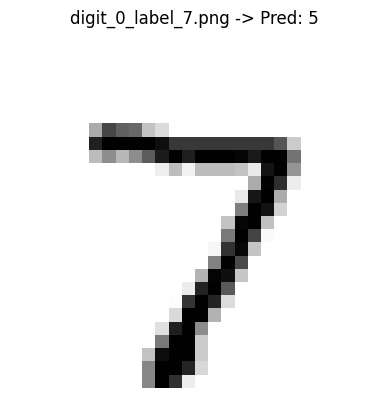

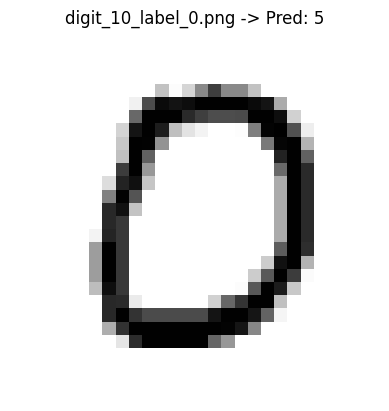

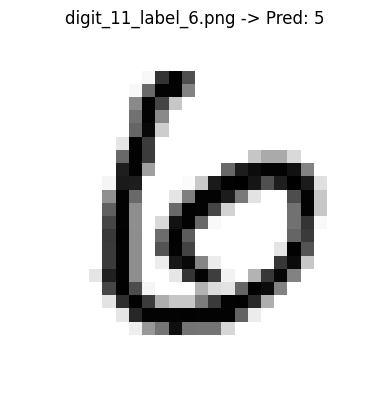

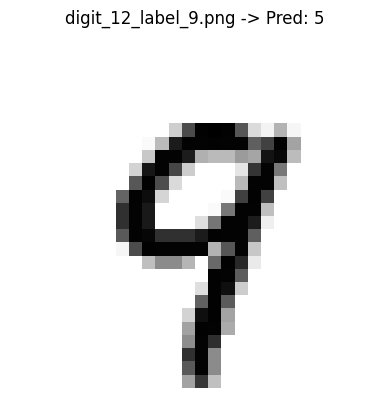

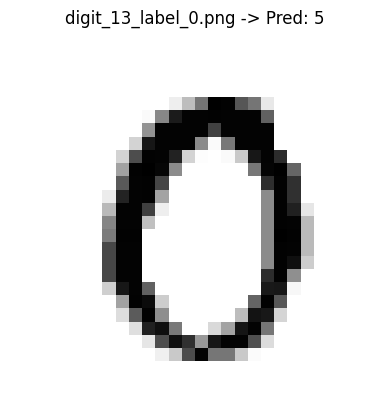

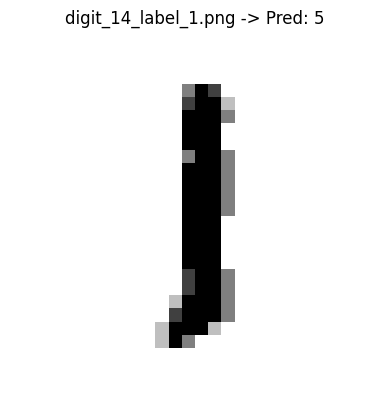

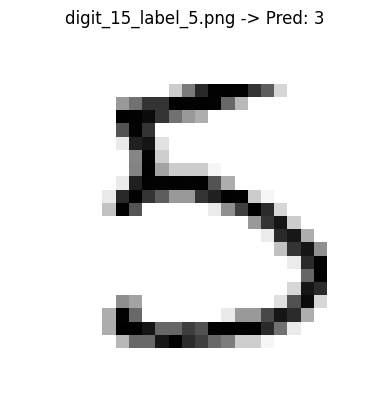

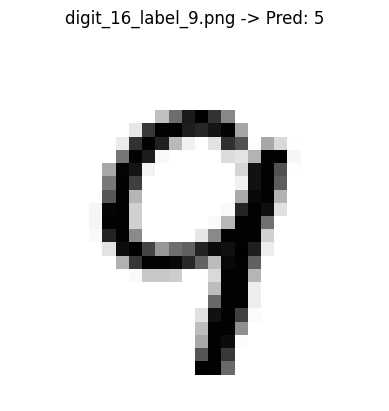

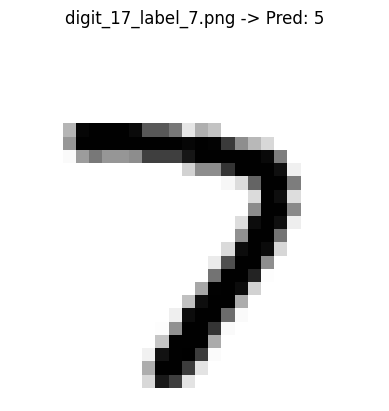

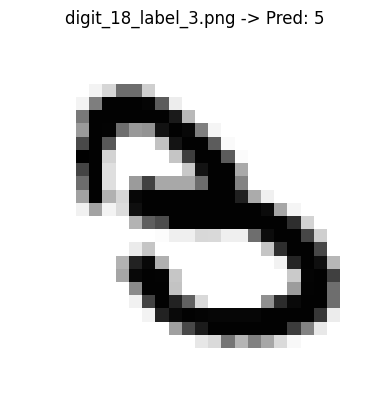

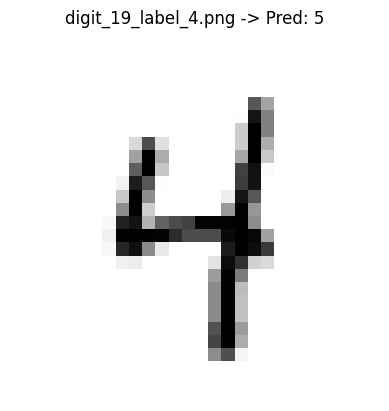

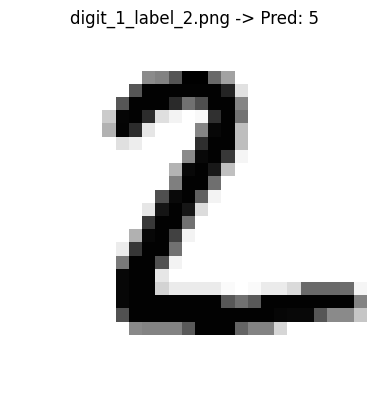

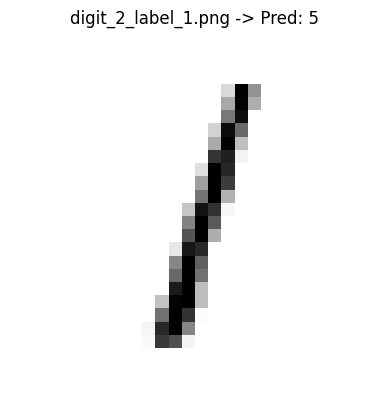

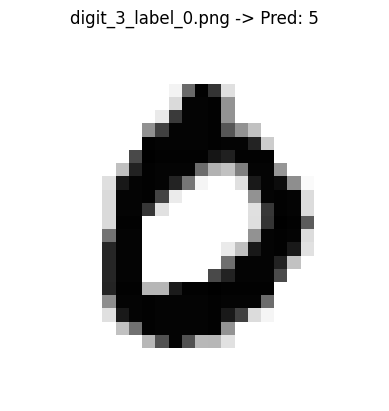

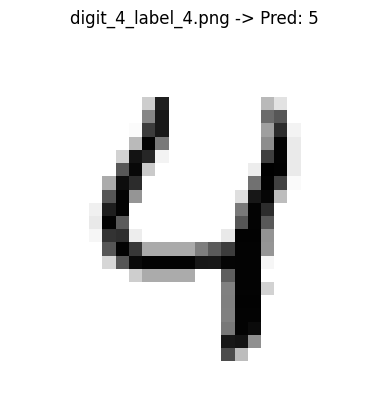

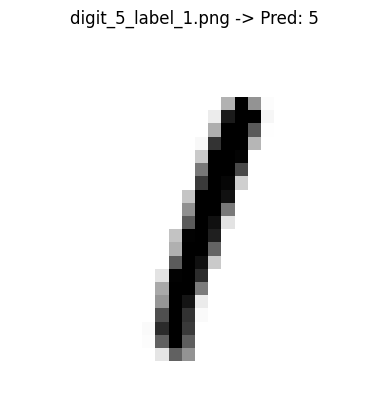

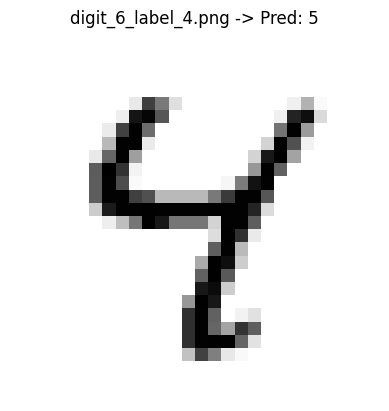

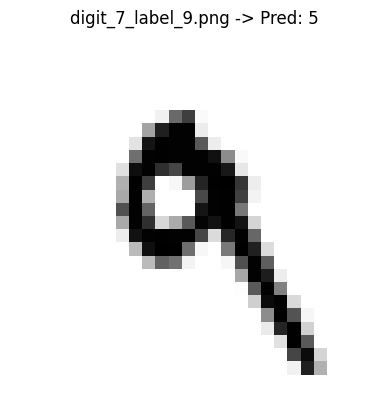

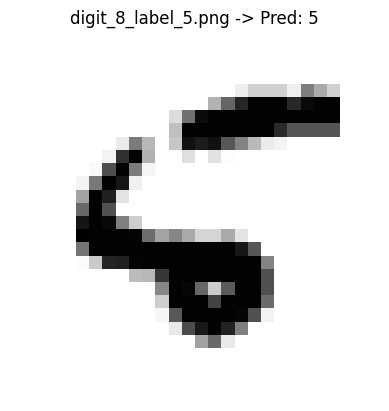

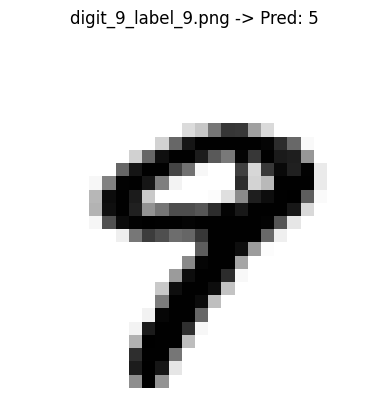

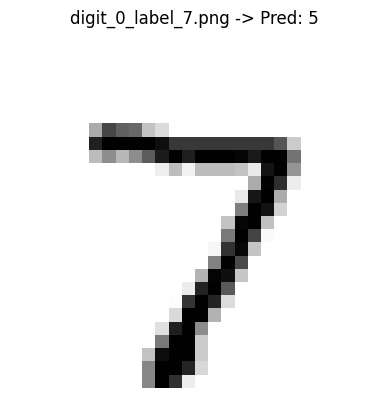

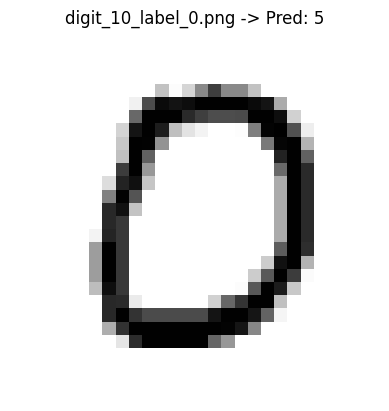

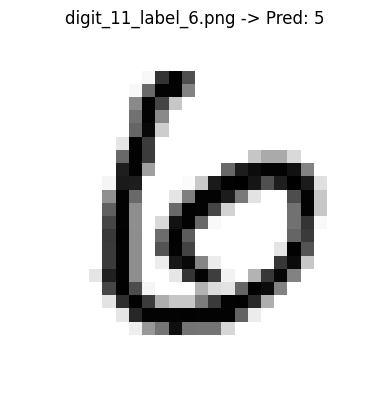

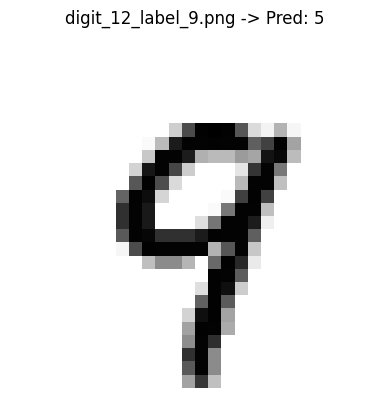

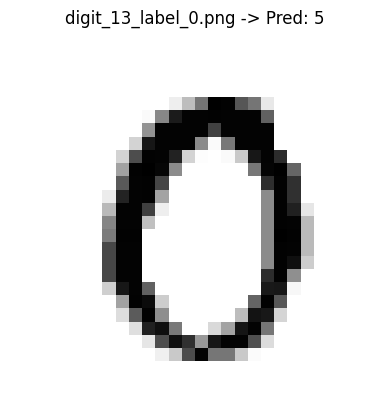

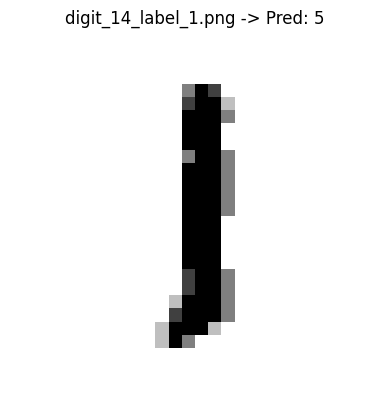

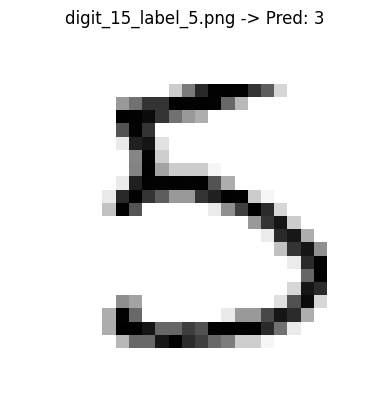

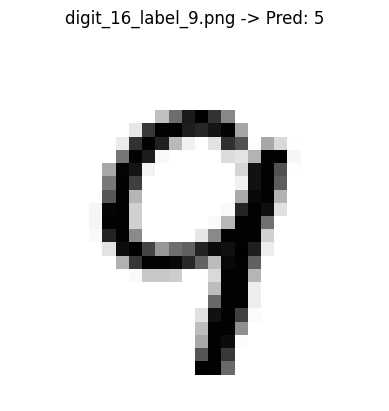

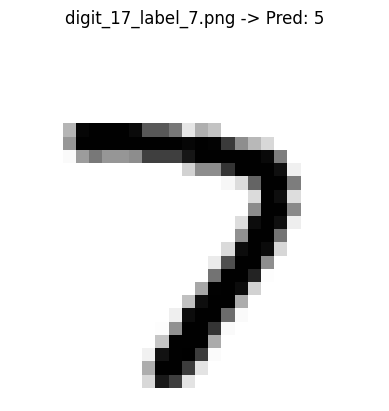

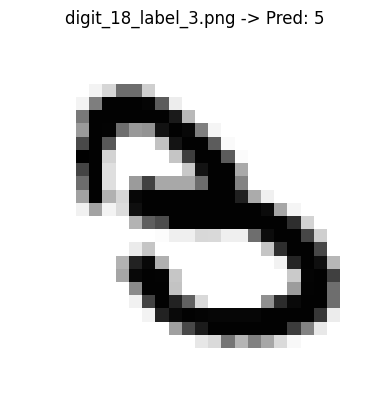

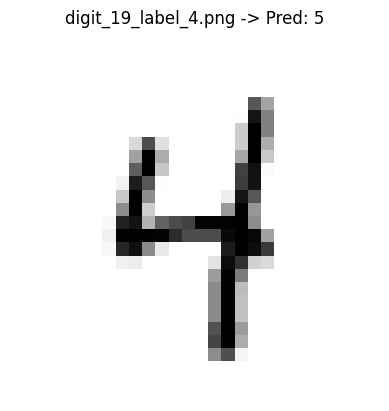

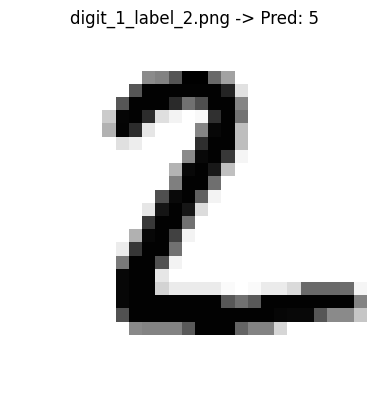

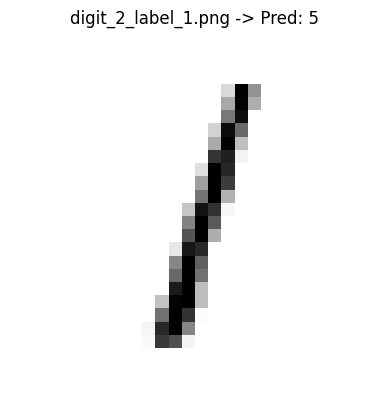

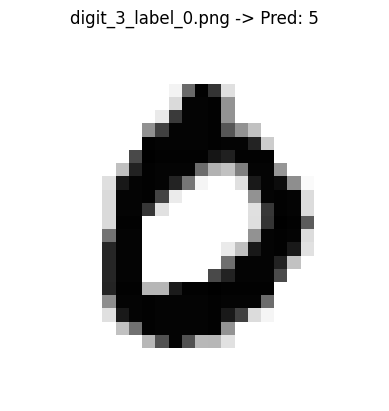

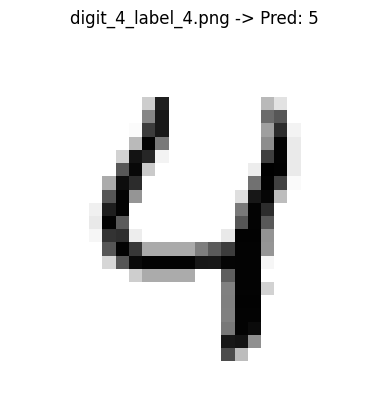

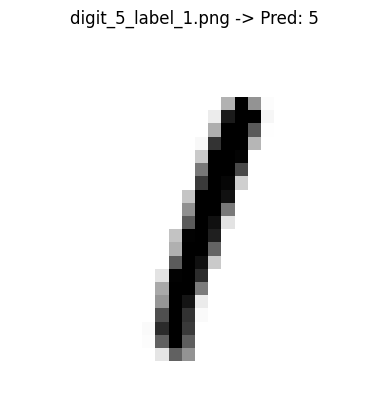

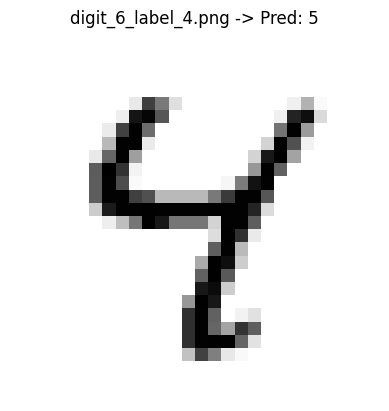

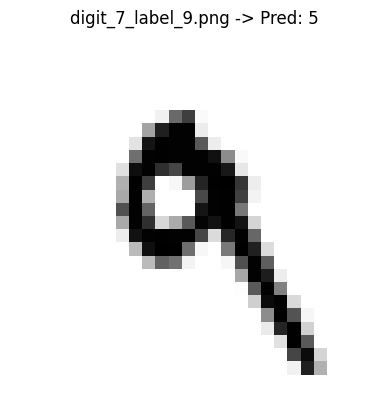

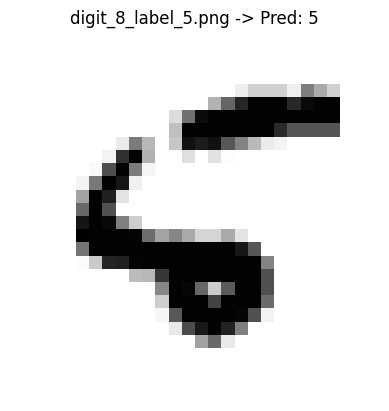

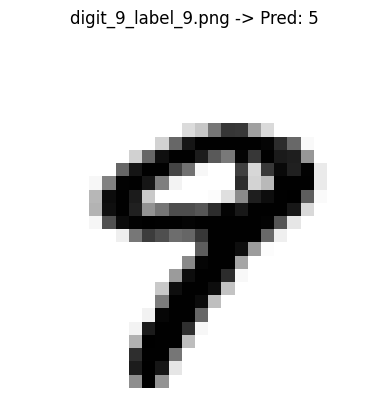

In [9]:
# ✅ Cell 8: Run helper function on saved PNGs
# First, reload the trained model
model = SmallMLP().to(device)
model.load_state_dict(torch.load("mlp_mnist_state_dict.pth", map_location=device))
model.eval()

# Call helper function
predict_from_folder(model, device, folder="saved_digits")
# ✅ Cell 8: Run helper function on saved PNGs
# First, reload the trained model
model = SmallMLP().to(device)
model.load_state_dict(torch.load("mlp_mnist_state_dict.pth", map_location=device))
model.eval()

# Call helper function
predict_from_folder(model, device, folder="saved_digits")
